In [19]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# --- Credenciales de tu Base de Datos ---
DB_USER = "cryptonita_user"
DB_PASSWORD = "TIZavoltio999"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "cryptonita_db2"

# --- Creamos el motor de conexión a la base de datos ---
# La 'engine' es como el enchufe que nos permitirá comunicarnos con PostgreSQL
try:
    engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
    print("✅ Conexión al motor de la base de datos creada con éxito.")
except Exception as e:
    print(f"❌ Error al crear el motor de la base de datos: {e}")

✅ Conexión al motor de la base de datos creada con éxito.


In [20]:
# --- Definimos el ticker que queremos analizar ---
ticker_seleccionado = 'BTC-USD'

# --- Escribimos la consulta SQL ---
# Pedimos todas las columnas (*) de la tabla para el ticker que hemos elegido.
# Es MUY IMPORTANTE ordenar por fecha para que la serie temporal esté en el orden correcto.
query = f"""
SELECT *
FROM gnn_technical_features
WHERE ticker = '{ticker_seleccionado}'
ORDER BY date;
"""

# --- Ejecutamos la consulta y cargamos los datos en un DataFrame de Pandas ---
try:
    df = pd.read_sql_query(query, engine)
    print(f"✅ Datos cargados para {ticker_seleccionado}. Total de filas: {len(df)}")
    
    # Mostramos las primeras 5 filas para ver cómo son los datos
    display(df.head())
    
    # Mostramos información general del DataFrame (tipos de datos, nulos, etc.)
    df.info()

except Exception as e:
    print(f"❌ Error al cargar los datos: {e}")

✅ Datos cargados para BTC-USD. Total de filas: 2191


,id,ticker,date,timestamp_utc,return_1d,return_3d,return_7d,return_30d,volatility_7d,volatility_30d,...,macd_histogram,bollinger_upper,bollinger_middle,bollinger_lower,bollinger_position,volume_sma_20,volume_ratio,momentum_5d,momentum_10d,calculation_timestamp
0,12299,BTC-USD,2019-07-31,2019-07-31 02:00:00+02:00,0.049774,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,NaN,None,NaN,None,None,2025-08-04 08:32:28.686400+00:00
1,12300,BTC-USD,2019-08-01,2019-08-01 02:00:00+02:00,0.031137,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,NaN,None,NaN,None,None,2025-08-04 08:32:28.686400+00:00
2,12301,BTC-USD,2019-08-02,2019-08-02 02:00:00+02:00,0.011395,0.094797,NaN,NaN,0.019192,NaN,...,None,None,None,None,NaN,None,NaN,None,None,2025-08-04 08:32:28.686400+00:00
3,12302,BTC-USD,2019-08-03,2019-08-03 02:00:00+02:00,0.028860,0.072985,NaN,NaN,0.015699,NaN,...,None,None,None,None,NaN,None,NaN,None,None,2025-08-04 08:32:28.686400+00:00
4,12303,BTC-USD,2019-08-04,2019-08-04 02:00:00+02:00,0.013719,0.054859,NaN,NaN,0.015485,NaN,...,None,None,None,None,NaN,None,NaN,None,None,2025-08-04 08:32:28.686400+00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     2191 non-null   int64              
 1   ticker                 2191 non-null   object             
 2   date                   2191 non-null   object             
 3   timestamp_utc          2191 non-null   object             
 4   return_1d              2191 non-null   float64            
 5   return_3d              2189 non-null   float64            
 6   return_7d              2185 non-null   float64            
 7   return_30d             2162 non-null   float64            
 8   volatility_7d          2189 non-null   float64            
 9   volatility_30d         2177 non-null   float64            
 10  rsi_14                 2186 non-null   float64            
 11  ema_12                 2187 non-null   float64          

In [21]:
# Hacemos una copia para trabajar de forma segura
df_trabajo = df.copy()

# --- 1. Selección de columnas con umbral (esto se queda igual) ---
umbral_calidad = 95.0
completeness = df_trabajo.notna().sum() / len(df_trabajo) * 100
columnas_validas = completeness[completeness >= umbral_calidad].index.tolist()
columnas_a_excluir = ['id', 'ticker', 'timestamp_utc', 'calculation_timestamp', 'date']
features_finales = [col for col in columnas_validas if col not in columnas_a_excluir]

# --- 2. Creamos nuestro DataFrame final ---
df_final = df_trabajo[features_finales].copy()

# --- 3. Limpieza Definitiva en Dos Pasos ---
# 3.1: Forzamos conversión a numérico (importante hacerlo antes de rellenar)
for col in df_final.columns:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# 3.2: Rellenamos hacia adelante. Soluciona la mayoría de huecos.
df_final.fillna(method='ffill', inplace=True)

# 3.3: Rellenamos hacia atrás. Soluciona los posibles nulos del inicio.
df_final.fillna(method='bfill', inplace=True)

print("✅ Limpieza en dos pasos (ffill + bfill) completada.")
print("\nComprobación final de nulos en 'df_final':")
print(f"Total de NaNs restantes: {df_final.isnull().sum().sum()}")

print("\nAsí se ve nuestro DataFrame de entrenamiento final:")
display(df_final.head())

✅ Limpieza en dos pasos (ffill + bfill) completada.

Comprobación final de nulos en 'df_final':
Total de NaNs restantes: 0

Así se ve nuestro DataFrame de entrenamiento final:


/var/folders/z_/rcq9bsy13fzbphk_82m0p03r0000gn/T/ipykernel_74331/2944580932.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='ffill', inplace=True)
/var/folders/z_/rcq9bsy13fzbphk_82m0p03r0000gn/T/ipykernel_74331/2944580932.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)


,return_1d,return_3d,return_7d,return_30d,volatility_7d,volatility_30d,rsi_14,ema_12,ema_26,macd,macd_signal,bollinger_position,volume_ratio
0,0.049774,0.094797,0.194719,-0.01012,0.019192,0.040275,100.0,10523.106209,11270.135367,10.728938,5.960521,0.806,1.046
1,0.031137,0.094797,0.194719,-0.01012,0.019192,0.040275,100.0,10523.106209,11270.135367,23.409190,13.111615,0.806,1.046
2,0.011395,0.094797,0.194719,-0.01012,0.019192,0.040275,100.0,10523.106209,11270.135367,32.881326,19.808672,0.806,1.046
3,0.028860,0.072985,0.194719,-0.01012,0.015699,0.040275,100.0,10523.106209,11270.135367,49.415132,28.615924,0.806,1.046
4,0.013719,0.054859,0.194719,-0.01012,0.015485,0.040275,100.0,10523.106209,11270.135367,64.773502,38.416638,0.806,1.046


In [22]:
from sklearn.preprocessing import MinMaxScaler

# Creamos el objeto scaler. Lo guardamos porque lo necesitaremos
# más tarde para revertir la predicción a su valor original.
scaler = MinMaxScaler(feature_range=(0, 1))

# Aplicamos el escalado a nuestro DataFrame limpio
scaled_data = scaler.fit_transform(df_final)

print("✅ Datos normalizados. Todos los valores están ahora entre 0 y 1.")
# Muestra de los datos escalados (es un array de NumPy)
print(scaled_data[:5])

✅ Datos normalizados. Todos los valores están ahora entre 0 y 1.
[[0.75375385 0.72213374 0.76921642 0.29292205 0.10135244 0.38072365
  1.         0.03902559 0.04175187 0.41842648 0.40904097 0.806
  0.21231943]
 [0.72042349 0.72213374 0.76921642 0.29292205 0.10135244 0.38072365
  1.         0.03902559 0.04175187 0.41947422 0.40969904 0.806
  0.21231943]
 [0.68511696 0.72213374 0.76921642 0.29292205 0.10135244 0.38072365
  1.         0.03902559 0.04175187 0.42025688 0.41031533 0.806
  0.21231943]
 [0.71635131 0.68843856 0.76921642 0.29292205 0.07886758 0.38072365
  1.         0.03902559 0.04175187 0.42162303 0.4111258  0.806
  0.21231943]
 [0.6892732  0.66043752 0.76921642 0.29292205 0.07749004 0.38072365
  1.         0.03902559 0.04175187 0.42289205 0.4120277  0.806
  0.21231943]]


In [23]:
import numpy as np

# --- Parámetros ---
# ¿Qué columna de df_final queremos predecir? El retorno a 1 día es un buen objetivo.
# Necesitamos saber su posición.
target_column_index = df_final.columns.get_loc('return_1d')
# ¿Cuántos días de historial usará el modelo para cada predicción?
N_STEPS = 30

# --- Creamos las secuencias X (entrada) e y (salida) ---
X = []
y = []

for i in range(N_STEPS, len(scaled_data)):
    # X: La secuencia son los N_STEPS días anteriores de TODAS las características
    X.append(scaled_data[i-N_STEPS:i, :])
    # y: El objetivo es el valor de la columna 'return_1d' del día actual
    y.append(scaled_data[i, target_column_index])

# Convertimos las listas a arrays de NumPy, el formato que TensorFlow necesita
X = np.array(X)
y = np.array(y)

print(f"\n✅ Se han creado las secuencias.")
print(f"Forma de los datos de entrada (X): {X.shape}")
print(f"Forma de los datos de salida (y): {y.shape}")


✅ Se han creado las secuencias.
Forma de los datos de entrada (X): (2161, 30, 13)
Forma de los datos de salida (y): (2161,)


In [24]:
# --- Decidimos el punto de corte (el 80% de los datos) ---
split_index = int(len(X) * 0.8)

# --- Realizamos la división ---
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("✅ Datos divididos en conjuntos de entrenamiento y prueba.")
print("-" * 50)
print("Forma de los datos de entrenamiento (X_train):", X_train.shape)
print("Forma de las respuestas de entrenamiento (y_train):", y_train.shape)
print("-" * 50)
print("Forma de los datos de prueba (X_test):", X_test.shape)
print("Forma de las respuestas de prueba (y_test):", y_test.shape)

✅ Datos divididos en conjuntos de entrenamiento y prueba.
--------------------------------------------------
Forma de los datos de entrenamiento (X_train): (1728, 30, 13)
Forma de las respuestas de entrenamiento (y_train): (1728,)
--------------------------------------------------
Forma de los datos de prueba (X_test): (433, 30, 13)
Forma de las respuestas de prueba (y_test): (433,)


In [25]:
import numpy as np

print("--- 🕵️‍♂️ INICIANDO DIAGNÓSTICO PROFUNDO 🕵️‍♂️ ---")

# --- Diagnóstico 1: Comprobar el DataFrame DESPUÉS de la limpieza y el ffill ---
print("\n--- 1. Diagnóstico del DataFrame 'df_final' (antes de escalar) ---")
try:
    nulos_df_final = df_final.isnull().sum().sum()
    print(f"Número total de valores nulos (NaN) en df_final: {nulos_df_final}")

    # isna() no detecta infinitos, hay que buscarlos explícitamente.
    infinitos_df_final = np.isinf(df_final).sum().sum()
    print(f"Número total de valores infinitos (inf) en df_final: {infinitos_df_final}")

    if nulos_df_final > 0 or infinitos_df_final > 0:
        print("🚨 ¡ALERTA! Se encontraron problemas en 'df_final' ANTES de escalar.")
        if infinitos_df_final > 0:
            print("   >>> Causa probable: Valores infinitos. Esto suele ocurrir por divisiones entre cero en el cálculo de algún indicador.")
    else:
        print("   ✅ 'df_final' parece limpio (sin NaN ni Inf).")

except NameError:
    print("   ❌ La variable 'df_final' no existe. Asegúrate de ejecutar la celda de limpieza primero.")


# --- Diagnóstico 2: Comprobar los datos DESPUÉS de la normalización ---
print("\n--- 2. Diagnóstico de 'scaled_data' (post-normalización) ---")
try:
    nulos_scaled = np.isnan(scaled_data).sum()
    infinitos_scaled = np.isinf(scaled_data).sum()
    print(f"Número total de NaN en scaled_data: {nulos_scaled}")
    print(f"Número total de Inf en scaled_data: {infinitos_scaled}")

    if nulos_scaled > 0 or infinitos_scaled > 0:
        print("🚨 ¡ALERTA! Se encontraron problemas DESPUÉS de la normalización.")
    else:
        print("   ✅ 'scaled_data' parece limpio.")
except NameError:
    print("   ❌ La variable 'scaled_data' no existe. Asegúrate de ejecutar la celda de normalización.")


# --- Diagnóstico 3: Comprobar los datos finales X e y ---
print("\n--- 3. Diagnóstico de las secuencias finales 'X' e 'y' ---")
try:
    nulos_X = np.isnan(X).sum()
    infinitos_X = np.isinf(X).sum()
    print(f"Número total de NaN en X: {nulos_X}")
    print(f"Número total de Inf en X: {infinitos_X}")

    nulos_y = np.isnan(y).sum()
    infinitos_y = np.isinf(y).sum()
    print(f"Número total de NaN en y: {nulos_y}")
    print(f"Número total de Inf en y: {infinitos_y}")

    if nulos_X > 0 or nulos_y > 0 or infinitos_X > 0 or infinitos_y > 0:
        print("🚨 ¡ALERTA! Se encontraron problemas en los arrays finales para el modelo.")
    else:
        print("   ✅ Los arrays 'X' e 'y' para el modelo parecen limpios.")
except NameError:
    print("   ❌ Las variables 'X' o 'y' no existen. Asegúrate de ejecutar la celda de creación de ventanas.")

print("\n--- DIAGNÓSTICO COMPLETADO ---")

--- 🕵️‍♂️ INICIANDO DIAGNÓSTICO PROFUNDO 🕵️‍♂️ ---

--- 1. Diagnóstico del DataFrame 'df_final' (antes de escalar) ---
Número total de valores nulos (NaN) en df_final: 0
Número total de valores infinitos (inf) en df_final: 0
   ✅ 'df_final' parece limpio (sin NaN ni Inf).

--- 2. Diagnóstico de 'scaled_data' (post-normalización) ---
Número total de NaN en scaled_data: 0
Número total de Inf en scaled_data: 0
   ✅ 'scaled_data' parece limpio.

--- 3. Diagnóstico de las secuencias finales 'X' e 'y' ---
Número total de NaN en X: 0
Número total de Inf en X: 0
Número total de NaN en y: 0
Número total de Inf en y: 0
   ✅ Los arrays 'X' e 'y' para el modelo parecen limpios.

--- DIAGNÓSTICO COMPLETADO ---


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# --- Creamos el esqueleto del modelo ---
model = Sequential()

# --- Capa 1: La primera LSTM, la puerta de entrada ---
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# --- Capa 2: Un Dropout para regularizar ---
model.add(Dropout(0.2))

# --- Capa 3: Una segunda LSTM para profundizar en los patrones ---
model.add(LSTM(units=50, return_sequences=False))

# --- Capa 4: Otro Dropout ---
model.add(Dropout(0.2))

# --- Capa 5: La capa de salida final ---
model.add(Dense(units=1))


# --- Imprimimos un resumen de nuestro modelo ---
model.summary()

/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.optimizers import Adam

# --- Creamos una instancia del optimizador Adam ---
# Y le añadimos nuestra red de seguridad: clipvalue=1.0
# Esto "recortará" cualquier gradiente que supere el valor de 1.0
optimizer_con_clip = Adam(clipvalue=1.0)

# --- Compilamos el modelo usando nuestro nuevo optimizador seguro ---
model.compile(optimizer=optimizer_con_clip, loss='mean_squared_error')

print("✅ Modelo compilado con 'gradient clipping'. Listo para un entrenamiento seguro.")

✅ Modelo compilado con 'gradient clipping'. Listo para un entrenamiento seguro.


Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 10/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 11/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 12/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

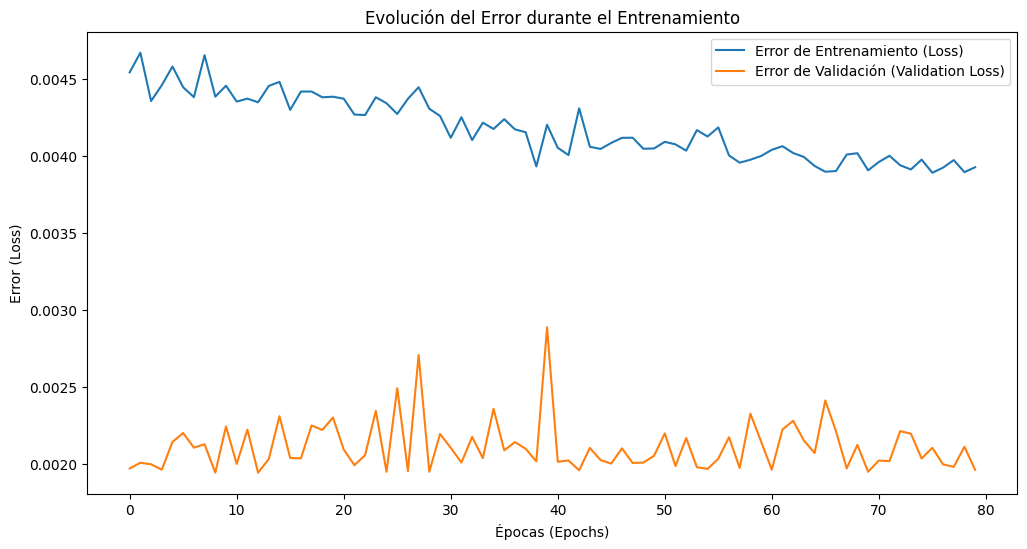

In [ ]:
# --- Parámetros de Entrenamiento ---
EPOCHS = 50
BATCH_SIZE = 32

# --- ¡Iniciamos el entrenamiento! ---
# Guardamos el proceso en una variable 'history' para poder graficarlo después.
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

# --- Visualizamos el proceso de aprendizaje ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Error de Entrenamiento (Loss)')
plt.plot(history.history['val_loss'], label='Error de Validación (Validation Loss)')
plt.title('Evolución del Error durante el Entrenamiento')
plt.xlabel('Épocas (Epochs)')
plt.ylabel('Error (Loss)')
plt.legend()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✅ Error Final (RMSE) en la escala original: 0.024781


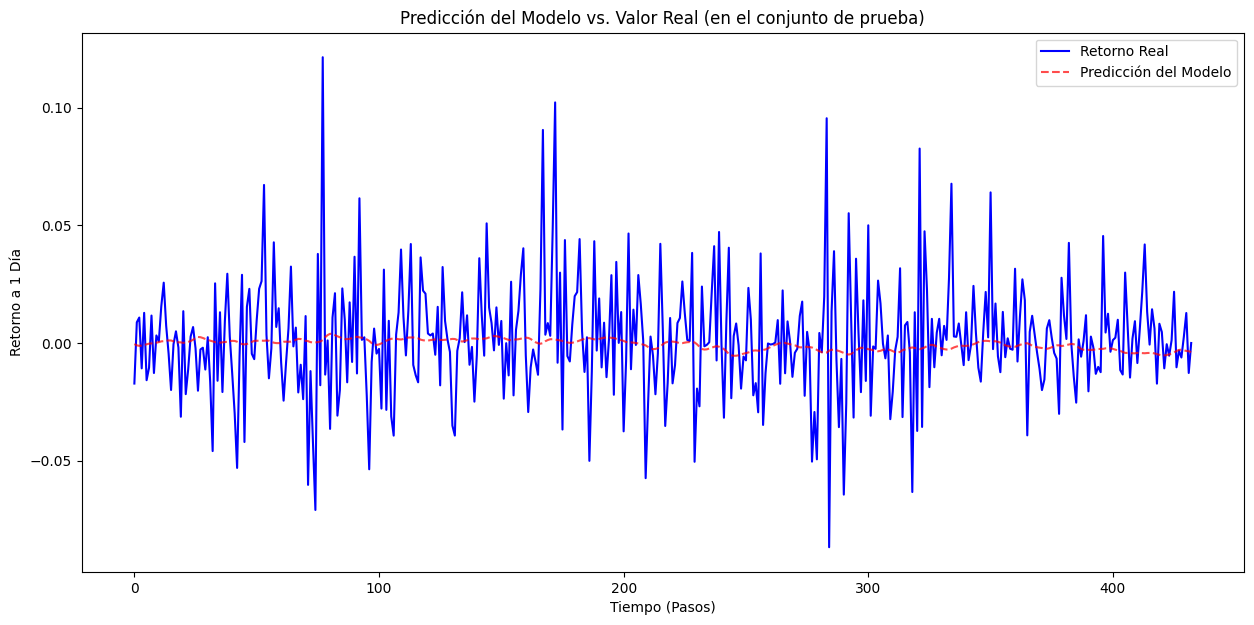

In [30]:
# --- 1. Hacemos las predicciones sobre el conjunto de prueba ---
predictions_scaled = model.predict(X_test)

# --- 2. Deshacemos la normalización para entender los resultados ---
# ¡Paso importante! El scaler fue entrenado con 14 columnas, así que para invertir la
# transformación, debemos darle un array con esa misma forma.

# Creamos un array "plantilla" con la misma forma que los datos originales (lleno de ceros)
dummy_array = np.zeros((len(predictions_scaled), df_final.shape[1]))

# Ponemos nuestras predicciones escaladas en la columna correcta (la del 'return_1d')
target_column_index = df_final.columns.get_loc('return_1d')
dummy_array[:, target_column_index] = predictions_scaled.flatten()

# Ahora sí, invertimos la transformación
predictions_real = scaler.inverse_transform(dummy_array)[:, target_column_index]


# Hacemos lo mismo con los datos reales de 'y_test' para poder compararlos
dummy_array_y = np.zeros((len(y_test), df_final.shape[1]))
dummy_array_y[:, target_column_index] = y_test.flatten()
y_test_real = scaler.inverse_transform(dummy_array_y)[:, target_column_index]


# --- 3. Calculamos el error final (RMSE) en la escala real ---
from sklearn.metrics import mean_squared_error
rmse_final = np.sqrt(mean_squared_error(y_test_real, predictions_real))
print(f"✅ Error Final (RMSE) en la escala original: {rmse_final:.6f}")


# --- 4. Visualizamos las predicciones vs. la realidad ---
plt.figure(figsize=(15, 7))
plt.plot(y_test_real, color='blue', label='Retorno Real')
plt.plot(predictions_real, color='red', alpha=0.7, linestyle='--', label='Predicción del Modelo')
plt.title('Predicción del Modelo vs. Valor Real (en el conjunto de prueba)')
plt.xlabel('Tiempo (Pasos)')
plt.ylabel('Retorno a 1 Día')
plt.legend()
plt.show()

Columnas disponibles en nuestro DataFrame final: ['return_1d', 'return_3d', 'return_7d', 'return_30d', 'volatility_7d', 'volatility_30d', 'rsi_14', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'bollinger_position', 'volume_ratio']


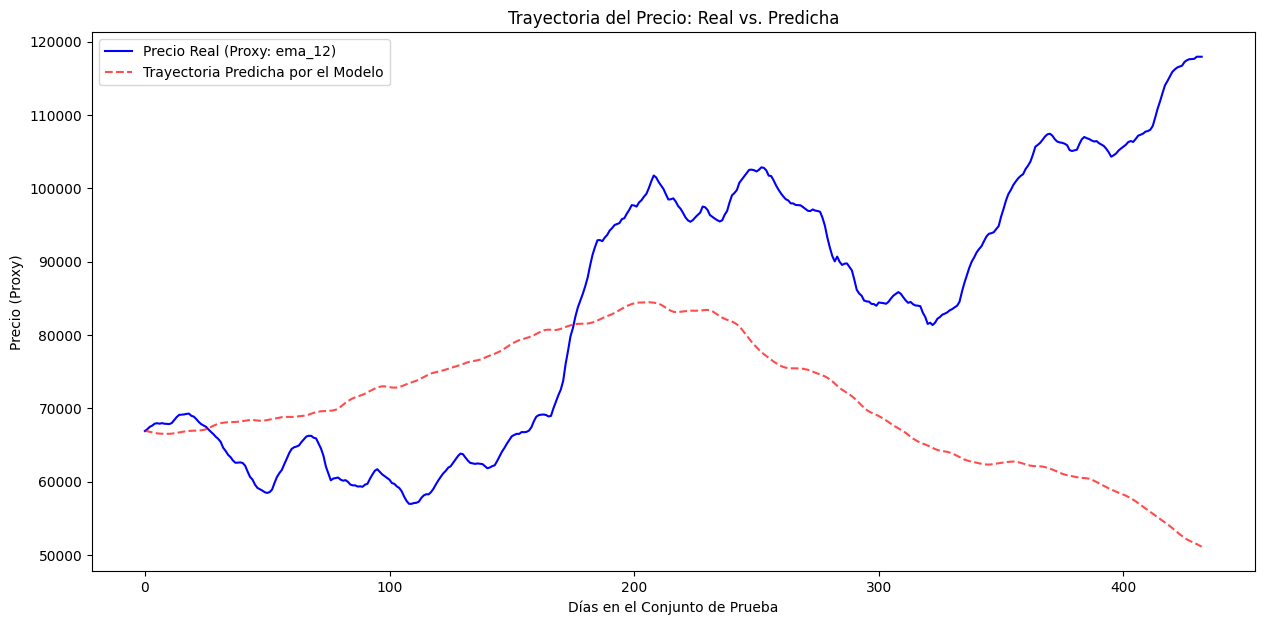

In [32]:
# --- Paso de Verificación: Veamos qué columnas sobrevivieron a la limpieza ---
print("Columnas disponibles en nuestro DataFrame final:", df_final.columns.tolist())

# --- 1. Seleccionamos una columna PROXY para el precio que SÍ EXISTA ---
# 'ema_12' o 'ema_26' son excelentes opciones si están disponibles. Vamos a usar 'ema_12'.
# Si no estuviera, elige otra de la lista que se imprimió arriba.
PROXY_PRECIO_COL = 'ema_12'

# Obtenemos la serie de precios (proxy) reales para nuestro conjunto de prueba
test_data_start_index = len(df_final) - len(X_test)
precios_reales_test = df_final[PROXY_PRECIO_COL].iloc[test_data_start_index:].values


# --- 2. Construir la trayectoria del precio predicho (esta parte no cambia) ---
# Empezamos nuestra trayectoria con el primer precio real del conjunto de prueba.
trayectoria_predicha = [precios_reales_test[0]]

# Iteramos a través de los retornos que nuestro modelo predijo
for i in range(len(predictions_real) - 1):
    # Calculamos el siguiente precio predicho basándonos en el ÚLTIMO precio PREDICHO
    precio_siguiente = trayectoria_predicha[-1] * (1 + predictions_real[i])
    trayectoria_predicha.append(precio_siguiente)


# --- 3. Graficar ambas trayectorias ---
plt.figure(figsize=(15, 7))
plt.plot(precios_reales_test, color='blue', label=f'Precio Real (Proxy: {PROXY_PRECIO_COL})')
plt.plot(trayectoria_predicha, color='red', alpha=0.7, linestyle='--', label='Trayectoria Predicha por el Modelo')
plt.title('Trayectoria del Precio: Real vs. Predicha')
plt.xlabel('Días en el Conjunto de Prueba')
plt.ylabel('Precio (Proxy)')
plt.legend()
plt.show()

In [33]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import logging
from sqlalchemy import create_engine, text
from datetime import datetime

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("🛠️ CRYPTONITA GNN - FEATURE ENGINEERING PIPELINE")
print("=" * 60)

# ====================================================================
# CONFIGURACIÓN
# ====================================================================

# Configuración de base de datos (debe coincidir con tu script de ingesta)
DB_CONFIG = {
    'user': 'cryptonita_user',
    'password': 'TIZavoltio999',
    'host': 'localhost',
    'port': '5432',
    'database': 'cryptonita_db2'
}

# Nombre de la tabla de salida
OUTPUT_TABLE_NAME = 'gnn_master_features'

# ====================================================================
# FUNCIONES DE CONEXIÓN Y UTILIDADES
# ====================================================================

def create_db_connection():
    """Crea conexión a la base de datos PostgreSQL"""
    try:
        db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
        engine = create_engine(db_url)
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        logging.info("✅ Conexión a base de datos establecida")
        return engine
    except Exception as e:
        logging.error(f"❌ Error conectando a la base de datos: {e}")
        return None

# ====================================================================
# FASE 1: CARGA DE DATOS BRUTOS
# ====================================================================

def load_raw_data(engine) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Carga las tablas de datos brutos desde la base de datos."""
    logging.info("📥 FASE 1: Cargando datos brutos desde la base de datos...")
    try:
        df_prices = pd.read_sql("SELECT * FROM gnn_crypto_prices ORDER BY date", engine)
        df_macro = pd.read_sql("SELECT * FROM gnn_macro_indicators ORDER BY date", engine)
        df_funding = pd.read_sql("SELECT * FROM gnn_funding_rates ORDER BY date", engine)

        # Convertir 'date' a datetime para asegurar la compatibilidad
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        df_macro['date'] = pd.to_datetime(df_macro['date'])
        df_funding['date'] = pd.to_datetime(df_funding['date'])

        logging.info(f"   ✅ Precios Crypto: {len(df_prices):,} registros cargados.")
        logging.info(f"   ✅ Datos Macro: {len(df_macro):,} registros cargados.")
        logging.info(f"   ✅ Funding Rates: {len(df_funding):,} registros cargados.")
        return df_prices, df_macro, df_funding
    except Exception as e:
        logging.error(f"   ❌ Error al cargar datos brutos: {e}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# ====================================================================
# FASE 2: INGENIERÍA DE CARACTERÍSTICAS
# ====================================================================

def calculate_technical_indicators(df_prices: pd.DataFrame) -> pd.DataFrame:
    """Calcula un conjunto de indicadores técnicos para cada ticker."""
    logging.info("📈 FASE 2.1: Calculando indicadores técnicos...")
    all_tickers_features = []

    for ticker in df_prices['ticker'].unique():
        df_ticker = df_prices[df_prices['ticker'] == ticker].copy()
        df_ticker.set_index('date', inplace=True)

        # Usar pandas_ta para calcular indicadores
        # RSI
        df_ticker.ta.rsi(length=14, append=True)
        # MACD
        df_ticker.ta.macd(fast=12, slow=26, signal=9, append=True)
        # Bandas de Bollinger
        df_ticker.ta.bbands(length=20, std=2, append=True)
        # Volatilidad (usando Average True Range)
        df_ticker.ta.atr(length=14, append=True)

        df_ticker.reset_index(inplace=True)
        all_tickers_features.append(df_ticker)

    df_with_features = pd.concat(all_tickers_features, ignore_index=True)
    logging.info(f"   ✅ Indicadores técnicos calculados para {len(df_prices['ticker'].unique())} tickers.")
    return df_with_features

def process_macro_data(df_macro: pd.DataFrame) -> pd.DataFrame:
    """Pivota y prepara los datos macroeconómicos."""
    logging.info("🌍 FASE 2.2: Procesando datos macroeconómicos...")
    # Pivota la tabla para tener cada indicador macro como una columna
    df_macro_pivot = df_macro.pivot_table(
        index='date',
        columns='indicator_symbol',
        values='close_value'
    )
    # Renombra las columnas para mayor claridad
    df_macro_pivot.columns = [f"macro_{col.lower()}" for col in df_macro_pivot.columns]

    # Rellena los huecos (ej. fines de semana) con el último valor conocido
    df_macro_pivot.fillna(method='ffill', inplace=True)
    logging.info(f"   ✅ Datos macro pivotados y limpiados.")
    return df_macro_pivot

# ====================================================================
# FASE 3: UNIFICACIÓN Y CREACIÓN DEL DATAFRAME MAESTRO
# ====================================================================

def create_master_dataframe(df_prices_features: pd.DataFrame, df_macro_pivot: pd.DataFrame, df_funding: pd.DataFrame) -> pd.DataFrame:
    """Unifica todos los DataFrames en una única tabla maestra."""
    logging.info("🔗 FASE 3: Creando el DataFrame Maestro...")

    # 1. Empezamos con los precios y sus características técnicas
    df_master = df_prices_features

    # 2. Unimos los datos macro, alineando por fecha
    df_master = pd.merge(df_master, df_macro_pivot, on='date', how='left')

    # 3. Unimos los funding rates, alineando por ticker y fecha
    # Seleccionamos solo las columnas necesarias de funding rates
    df_funding_subset = df_funding[['date', 'ticker', 'funding_rate']]
    df_master = pd.merge(df_master, df_funding_subset, on=['date', 'ticker'], how='left')

    # Rellenar cualquier nulo que pueda quedar después de los merges
    # Los datos macro se rellenan hacia adelante
    macro_cols = [col for col in df_master.columns if 'macro_' in col]
    df_master[macro_cols] = df_master[macro_cols].fillna(method='ffill')
    # Los funding rates nulos se rellenan con 0 (asumiendo neutralidad)
    df_master['funding_rate'].fillna(0, inplace=True)

    # Eliminar filas que todavía puedan tener nulos (especialmente al principio)
    df_master.dropna(inplace=True)

    logging.info(f"   ✅ DataFrame Maestro creado con {len(df_master):,} filas y {len(df_master.columns)} columnas.")
    return df_master

# ====================================================================
# FASE 4: GUARDADO EN BASE DE DATOS
# ====================================================================

def save_master_dataframe(engine, df_master: pd.DataFrame):
    """Guarda el DataFrame maestro en una nueva tabla en la base de datos."""
    logging.info(f"💾 FASE 4: Guardando DataFrame Maestro en la tabla '{OUTPUT_TABLE_NAME}'...")
    try:
        with engine.connect() as conn:
            with conn.begin() as trans:
                # Truncar la tabla si ya existe para asegurar datos frescos
                conn.execute(text(f"TRUNCATE TABLE {OUTPUT_TABLE_NAME} RESTART IDENTITY"))
                df_master.to_sql(
                    OUTPUT_TABLE_NAME,
                    conn,
                    if_exists='append',
                    index=False,
                    method='multi'
                )
        
        # Verificación
        with engine.connect() as conn:
            count = conn.execute(text(f"SELECT COUNT(*) FROM {OUTPUT_TABLE_NAME}")).scalar()
        logging.info(f"   ✅ VERIFICACIÓN: {count:,} registros insertados en '{OUTPUT_TABLE_NAME}'.")
        return True
    except Exception as e:
        logging.error(f"   ❌ Error al guardar el DataFrame Maestro: {e}")
        return False

# ====================================================================
# FUNCIÓN PRINCIPAL
# ====================================================================

def run_feature_engineering():
    """Ejecuta el pipeline completo de ingeniería de características."""
    print("\n🚀 INICIANDO PIPELINE DE INGENIERÍA DE CARACTERÍSTICAS")
    print("=" * 60)

    start_time = datetime.now()

    engine = create_db_connection()
    if not engine:
        return

    # FASE 1
    df_prices, df_macro, df_funding = load_raw_data(engine)
    if df_prices.empty or df_macro.empty:
        logging.error("No se pudieron cargar los datos base. Abortando.")
        return

    # FASE 2
    df_prices_features = calculate_technical_indicators(df_prices)
    df_macro_pivot = process_macro_data(df_macro)

    # FASE 3
    df_master = create_master_dataframe(df_prices_features, df_macro_pivot, df_funding)
    if df_master.empty:
        logging.error("El DataFrame Maestro está vacío después de la unificación. Revisar datos de entrada.")
        return

    # FASE 4
    save_master_dataframe(engine, df_master)

    duration = datetime.now() - start_time
    print("\n" + "=" * 60)
    print("🎉 PIPELINE DE INGENIERÍA DE CARACTERÍSTICAS COMPLETADO")
    print(f"⏱️ Tiempo total: {duration}")
    print(f"✅ Tabla '{OUTPUT_TABLE_NAME}' creada y lista para ser usada en el modelo.")
    print("=" * 60)


if __name__ == "__main__":
    run_feature_engineering()


/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


ImportError: cannot import name 'NaN' from 'numpy' (/Users/User/Library/CloudStorage/GoogleDrive-ignaciovct99@gmail.com/Mi unidad/Documentos/PROYECTOS/CRYPTONITA/cryptonita/.venv/lib/python3.11/site-packages/numpy/__init__.py)

Mapa de calor guardado.
Histograma de distribución guardado.
Gráfico de barras divergente guardado.


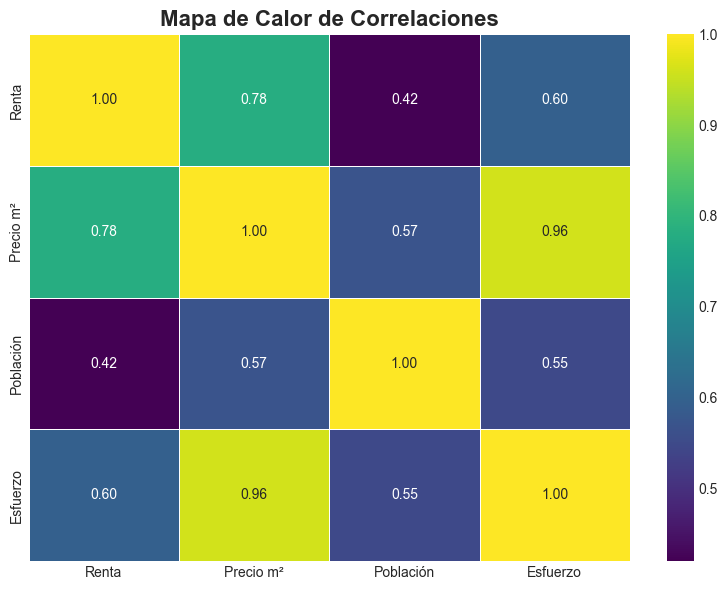

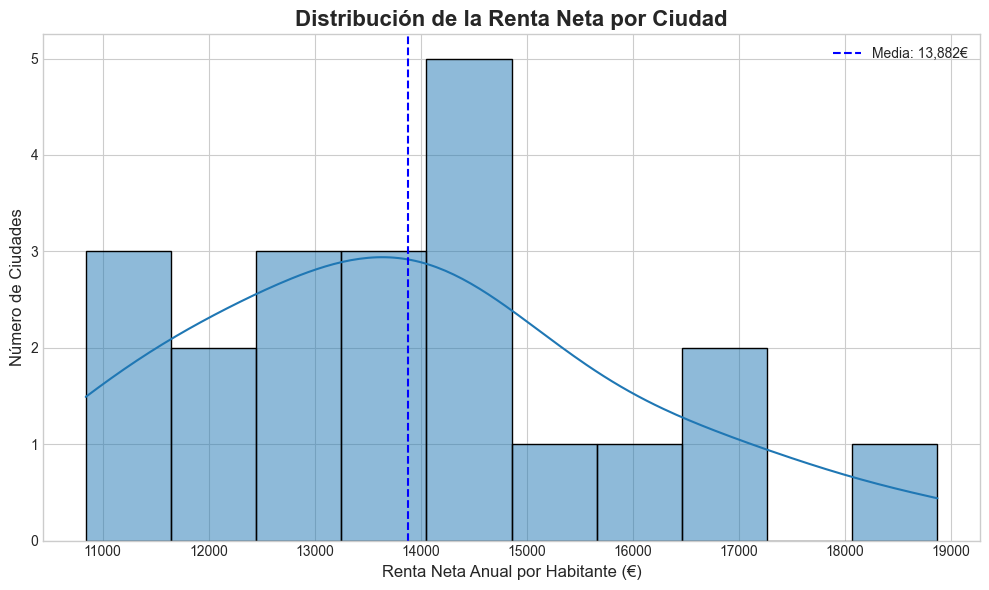

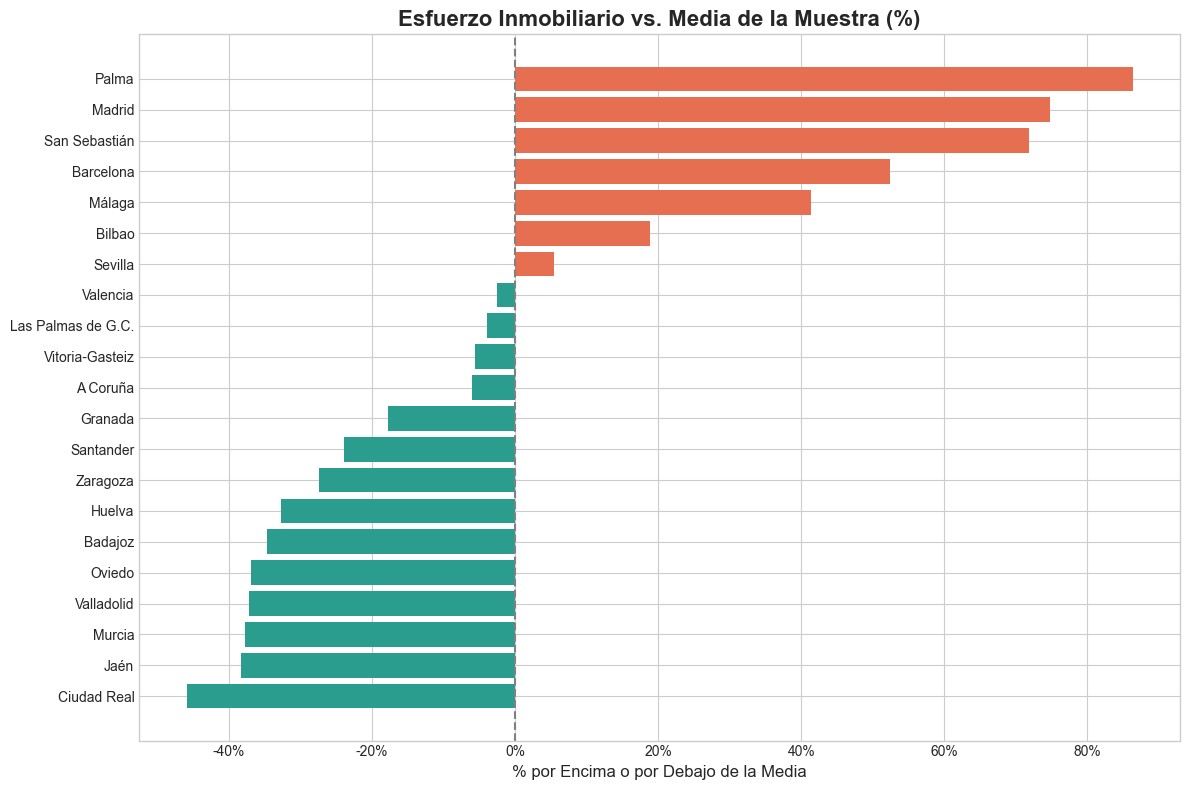

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos que ya hemos consolidado en pasos anteriores
data = {
    'Ciudad': [
        'Madrid', 'Barcelona', 'San Sebastián', 'Bilbao', 'Valencia', 'Sevilla',
        'Zaragoza', 'Málaga', 'Palma', 'Murcia', 'Las Palmas de G.C.', 'Valladolid',
        'A Coruña', 'Granada', 'Vitoria-Gasteiz', 'Oviedo', 'Santander', 'Jaén',
        'Badajoz', 'Huelva', 'Ciudad Real'
    ],
    'Renta_Neta_Anual_Habitante': [
        17030, 16894, 18874, 16119, 13643, 12457, 14116, 11985, 13712, 11840,
        12518, 14099, 14536, 13215, 15291, 14706, 14219, 10842, 11100, 10970, 13350
    ],
    'Precio_m2_Vivienda': [
        5718, 4943, 6230, 3680, 2552, 2521, 1968, 3254, 4907, 1414,
        2311, 1699, 2623, 2087, 2772, 1782, 2079, 1285, 1391, 1417, 1386
    ],
    'Poblacion': [
        3332035, 1660118, 188743, 346405, 807693, 684025, 682513, 586384,
        423350, 469177, 378027, 297451, 247362, 230595, 255886, 217584,
        172606, 111888, 150190, 142538, 75303
    ]
}

df = pd.DataFrame(data)
df['Indice_Esfuerzo'] = (df['Precio_m2_Vivienda'] * 80) / df['Renta_Neta_Anual_Habitante']

# --- 1. Mapa de Calor de Correlaciones ---
plt.style.use('seaborn-v0_8-whitegrid')
fig1, ax1 = plt.subplots(figsize=(8, 6))

# Seleccionar solo columnas numéricas para la correlación
numeric_df = df[['Renta_Neta_Anual_Habitante', 'Precio_m2_Vivienda', 'Poblacion', 'Indice_Esfuerzo']]
# Renombrar columnas para que quepan mejor en el gráfico
numeric_df.columns = ['Renta', 'Precio m²', 'Población', 'Esfuerzo']
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, ax=ax1)
ax1.set_title('Mapa de Calor de Correlaciones', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
print("Mapa de calor guardado.")


# --- 2. Histograma de Distribución de Renta ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
sns.histplot(df['Renta_Neta_Anual_Habitante'], kde=True, bins=10, ax=ax2)
mean_income = df['Renta_Neta_Anual_Habitante'].mean()
ax2.axvline(mean_income, color='blue', linestyle='--', label=f'Media: {mean_income:,.0f}€')
ax2.set_title('Distribución de la Renta Neta por Ciudad', fontsize=16, fontweight='bold')
ax2.set_xlabel('Renta Neta Anual por Habitante (€)', fontsize=12)
ax2.set_ylabel('Número de Ciudades', fontsize=12)
ax2.legend()
plt.tight_layout()
plt.savefig('income_distribution_histogram.png')
print("Histograma de distribución guardado.")


# --- 3. Gráfico de Barras Divergente ---
df_div = df[['Ciudad', 'Indice_Esfuerzo']].copy()
mean_effort = df_div['Indice_Esfuerzo'].mean()
df_div['Esfuerzo_vs_Media_%'] = ((df_div['Indice_Esfuerzo'] - mean_effort) / mean_effort) * 100
df_div = df_div.sort_values('Esfuerzo_vs_Media_%', ascending=False)
df_div['color'] = ['#2a9d8f' if x < 0 else '#e76f51' for x in df_div['Esfuerzo_vs_Media_%']]

fig3, ax3 = plt.subplots(figsize=(12, 8))
ax3.barh(df_div['Ciudad'], df_div['Esfuerzo_vs_Media_%'], color=df_div['color'])
ax3.axvline(0, color='grey', linestyle='--')
ax3.set_title('Esfuerzo Inmobiliario vs. Media de la Muestra (%)', fontsize=16, fontweight='bold')
ax3.set_xlabel('% por Encima o por Debajo de la Media', fontsize=12)
ax3.set_ylabel('')
ax3.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
# Invertir el eje Y para que la barra más alta esté arriba
ax3.invert_yaxis()
plt.tight_layout()
plt.savefig('diverging_barchart_effort.png')
print("Gráfico de barras divergente guardado.")